## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

In [2]:
def generate_random_overlap_circle_data(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms):
    N_channels = rows * cols
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations

    center_x, center_y = (rows - 1) / 2, (cols - 1) / 2
    max_distance = np.sqrt((center_x) ** 2 + (center_y) ** 2)

    # Initialize positions and neuron_data
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    distances = [np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) for x, y in positions]

    # Initialize train with empty lists for each channel
    train_patterned_circle = [[] for _ in range(N_channels)]
    
    # Pre-assign at least one firing event for each neuron across the propagations
    preassigned_firings = {neuron_index: random.randint(0, num_propagations - 1) for neuron_index in range(N_channels)}

    # Determine the radius increment per propagation
    radius_step = max_distance / num_propagations

    # Generate spike times based on the distance of each neuron from the center
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)
        for neuron_index, distance in enumerate(distances):
            # Determine when this neuron should fire within the current propagation segment
            # Adjust for overlap by ensuring the firing time is within the designated segment duration
            firing_time_within_segment = (distance / max_distance) * (segment_duration_ms - overlap_duration_ms)
            spike_time_start = segment_start + firing_time_within_segment
            spike_time_end = spike_time_start + overlap_duration_ms
            spike_times = np.linspace(spike_time_start, spike_time_end, int(overlap_duration_ms / 10))

            train_patterned_circle[neuron_index].extend(spike_times)

    # Convert lists to numpy arrays
    train_patterned_circle = [np.array(times) for times in train_patterned_circle]

    # Create the SpikeData object
    spike_data_patterned_circle = SpikeData(train=train_patterned_circle, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_patterned_circle

def generate_random_overlap_circle_data2(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms):
    N_channels = rows * cols
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations

    center_x, center_y = (rows - 1) / 2, (cols - 1) / 2
    max_distance = np.sqrt((center_x) ** 2 + (center_y) ** 2)

    # Initialize positions and neuron_data
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    distances = [np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) for x, y in positions]

    # Initialize train with empty lists for each channel
    train_patterned_circle = [[] for _ in range(N_channels)]
    
    # Generate spike times with specified overlap and randomness
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)
        segment_end = segment_start + segment_duration_ms
        for neuron_index, distance in enumerate(distances):
            normalized_distance = distance / max_distance
            # Calculate firing time with overlap between rings
            firing_time_start = segment_start + (normalized_distance * (segment_duration_ms - overlap_duration_ms)) - overlap_duration_ms / 2
            firing_time_end = firing_time_start + overlap_duration_ms

            # Adjust firing times to ensure they are within the segment
            firing_time_start = max(firing_time_start, segment_start)
            firing_time_end = min(firing_time_end, segment_end)

            # Random selection of neurons to fire
            if random.random() < 0.5:  # Adjust randomness threshold as needed
                if firing_time_start < firing_time_end:  # Only schedule firing if it has a valid range
                    spike_times = np.linspace(firing_time_start, firing_time_end, num=int(overlap_duration_ms / 10))
                    train_patterned_circle[neuron_index].extend(spike_times)

    # Convert lists to numpy arrays for each neuron's spike train
    train_patterned_circle = [np.array(times) for times in train_patterned_circle]

    # Create the SpikeData object
    spike_data_patterned_circle = SpikeData(train=train_patterned_circle, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_patterned_circle

# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def plot_raster(sd, title):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title(title)
    plt.show()

In [3]:
# def firing_plotter(sd, global_min_rate, global_max_rate):
#     # Custom colormap from pale red/pink to dark red/black
#     colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
#     cmap_name = "custom_red_black"
#     n_bins = 100  # More bins will give us a finer gradient
#     cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

#     firing_rates = calculate_mean_firing_rates(sd)
#     neuron_x, neuron_y = [], []
#     # Extract neuron positions
#     for i, neuron in sd.neuron_data['positions'].items():
#         neuron_x.append(neuron['position'][0])
#         neuron_y.append(neuron['position'][1])
    
#     plt.figure(figsize=(8, 6))
#     # Plotting a small pale blue square at each neuron position
#     plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)  # s is the size, c is the color
#     scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

#     plt.title("Neuron Firing Rates")
#     plt.xlabel("X Position")
#     plt.ylabel("Y Position")
#     plt.colorbar(scatter, label='Firing Rate (Hz)')
#     plt.gca().invert_yaxis()
#     # plt.show()

def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Synthetic Wave-Propagation Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

In [4]:
random_overlap_spike_data2 = generate_random_overlap_circle_data2(
    total_duration_ms=60 * 1000,  # 1 minute
    num_propagations=10,
    rows=16,
    cols=16,
    overlap_duration_ms=500,
    break_duration_ms=600  # 6 seconds
)

In [20]:
random_overlap_spike_data = generate_random_overlap_circle_data(
    total_duration_ms=60 * 1000,  # 1 minute
    num_propagations=8,
    rows=16,
    cols=16,
    overlap_duration_ms=500,
    break_duration_ms=2000  # 6 seconds
)

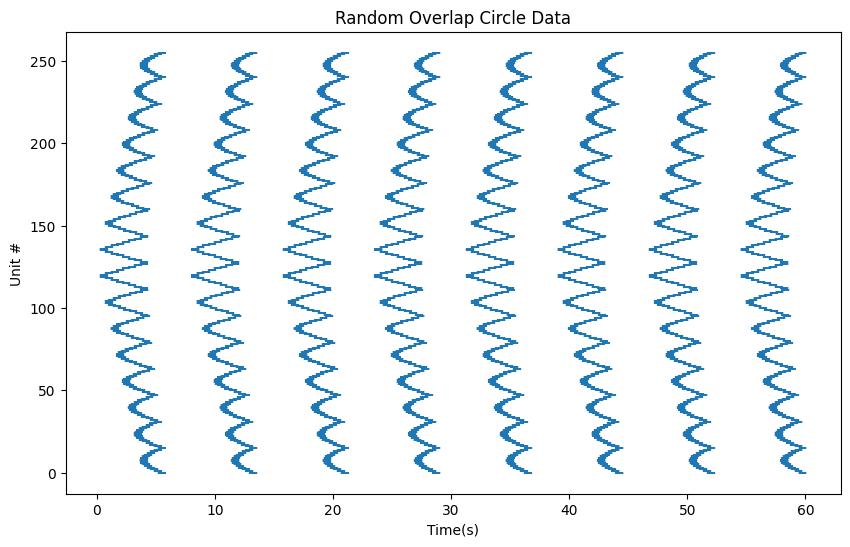

In [23]:
plot_raster(random_overlap_spike_data, 'Random Overlap Circle Data')

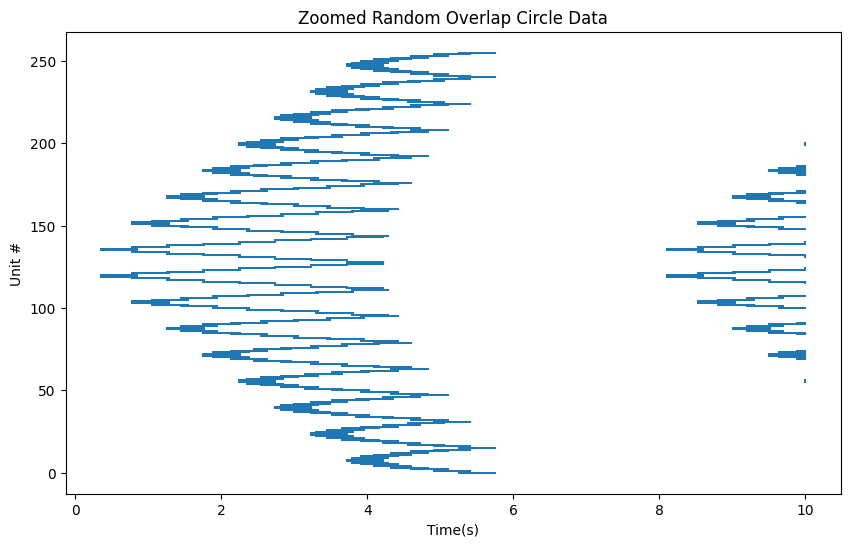

In [25]:
plot_raster(random_overlap_spike_data.subtime(0, 10000), 'Zoomed Random Overlap Circle Data')

In [27]:
os.getcwd()

'/workspaces/human_hippocampus/dev/other/thomas/thesis/synthetic'

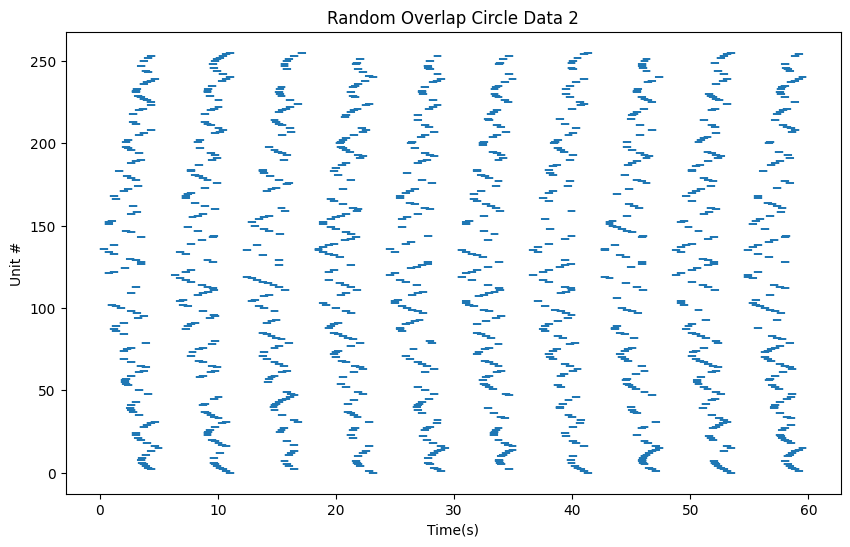

In [45]:
plot_raster(random_overlap_spike_data2, 'Random Overlap Circle Data 2')

In [24]:
np.mean(calculate_mean_firing_rates(random_overlap_spike_data2))

0.8333333333333335

In [59]:
def create_animation(sd, frames_per_second, output_dir='firing_maps', animation_file='circular_firing_animation_overlap2.gif'):
    base_path = "/workspaces/human_hippocampus/dev/other/thomas/thesis/saved_plots/"
    full_output_dir = os.path.join(base_path, output_dir)
    
    if not os.path.exists(full_output_dir):
        os.makedirs(full_output_dir)

    filenames = []
    
    # Adjust as necessary to capture the correct time segment
    # sd_test = sd.subtime(0, 10000)
    sd_test = sd
    total_recording_time_ms = sd_test.length  # Total recording time in milliseconds
    total_recording_time_s = total_recording_time_ms / 1000.0  # Convert ms to seconds

    # Calculate the total number of frames for the entire recording
    total_frames = int(frames_per_second * total_recording_time_s)
    
    # Calculate the global minimum and maximum firing rates for consistent coloring
    g_min_rate = np.min(calculate_mean_firing_rates(sd))
    g_max_rate = np.max(calculate_mean_firing_rates(sd))

    images = []
    for frame_number in range(total_frames):
        start_time_ms = (frame_number / frames_per_second) * 1000
        end_time_ms = ((frame_number + 1) / frames_per_second) * 1000
        sd_timestep = sd_test.subtime(start_time_ms, end_time_ms)
        
        firing_plotter(sd_timestep, global_min_rate=g_min_rate, global_max_rate=g_max_rate)
        
        filename = os.path.join(full_output_dir, f"frame_{frame_number}.png")
        plt.savefig(filename)
        plt.close()
        
        images.append(Image.open(filename))

    # Save frames to a GIF
    animation_path = os.path.join(base_path, animation_file)
    images[0].save(animation_path, save_all=True, append_images=images[1:], optimize=False, duration=int(1000 / frames_per_second), loop=0)
    
    print(f"Animation saved to {animation_path}")
    # return animation_path

In [60]:
create_animation(random_overlap_spike_data, 4)

/tmp/ipykernel_40159/87249695.py:37: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for i, neuron in sd.neuron_data['positions'].items():


Animation saved to /workspaces/human_hippocampus/dev/other/thomas/thesis/saved_plots/circular_firing_animation_overlap2.gif


In [61]:
file_path = os.path.join('/workspaces/human_hippocampus/dev/other/thomas/thesis/pickled_datasets/', 'circular_propagation_dataset.pkl')
with open(file_path, 'wb') as f:
    pickle.dump(random_overlap_spike_data, f)

In [6]:
with open('/workspaces/human_hippocampus/dev/other/thomas/thesis/pickled_datasets/propagation_dataset.pkl', 'rb') as file:
    loaded_object = pickle.load(file)